# 6.5   様々な性能評価指標
**適合率**    陽性クラスと予測したデータ点のうち，実際に陽性クラスだったものの割合
(真陽性)

**再現率**    真陽性率と同義語

**F1スコア**  適合率と再現率を組み合わせたもの

## 6.5.1  混同行列を解釈する
混同行列とは学習アルゴリズムの性能を明らかにする行列

真と偽は予測が当たったかどうか

陽性と陰性は予測されたクラスを表現

<img src="混同行列.png"  width="300">

In [1]:
#データセットを読み込む
import pandas as pd
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
               'breast-cancer-wisconsin/wdbc.data',header=None
)

In [2]:
from sklearn.preprocessing import LabelEncoder
X=df.loc[:,2:].values
y=df.loc[:,1].values
le=LabelEncoder()
y=le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,
                                               stratify=y, random_state=1)

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn. model_selection import StratifiedKFold

pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
pipe_svc.fit(X_train,y_train)
y_pred=pipe_svc.predict(X_test)

#テストと予測のデータから混同行列を生成
confmat=confusion_matrix(y_true=y_test,  y_pred=y_pred)
print(confmat)

[[105   2]
 [  6  58]]


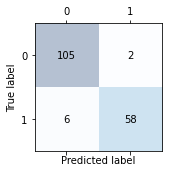

In [41]:
#図のサイズを指定
fig,ax=plt.subplots(figsize=(2.5,2.5))

#matshow関数で行列からヒートマップを描画
ax.matshow(confmat,cmap=plt.cm.Blues,  alpha=0.3)
for i in range(confmat.shape[0]):  #クラス0の繰り返し処理
    for j in range(confmat.shape[1]):  #クラス１の繰り返し処理
        ax.text(x=j, y=i, s=confmat[i,j], va='center',ha='center') #件数を表示
        
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# 6.5.2. 分類モデルの適合率と再現率を最適化する
<img src="混同行列.png"  width="400" align="right">
<br>
    (ERR)：予測の誤分類率&emsp;(ACC):正解率&emsp;(TPR):真陽性率 &emsp;(PRE):適合率 &emsp;(REC):再現率 
<br>
<br>
$$
\begin{align}
    ERR   &= \frac{FP+FN}{FP+FN+TP+TN}\\\\
    ACC  &= \frac{TP+TN}{FP+FN+TP+TN}= 1-ERR&\\\\ 
    TPR  &= \frac{TP}{ P}=\frac{TP}{TP+FN}\\\\
    PRE  &= \frac{TP}{TP+FP}\\\\
    F1   &= \frac{2\times PRE \times REC}{PRE+REC}\\
\end{align}
$$

In [42]:
#適合率，再現率，F1スコアを出力
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,  f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred) )
print('Recall:  %.3f' %  recall_score(y_true=y_test,  y_pred=y_pred))
print('F1:  %.3f' %  f1_score(y_true=y_test,  y_pred=y_pred))

Precision: 0.967
Recall:  0.906
F1:  0.935


In [46]:
#カスタムの性能指標を出力
from  sklearn.metrics import make_scorer,  f1_score
#from  sklearn.metrics import make_scorer,  precision_score
#from  sklearn.metrics import make_scorer,  recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
c_gamma_range=[0.01,  0.1,  1.0,  10.0]
param_grid=[{'svc__C':  c_gamma_range, 'svc__kernel' : ['linear']},
                        {'svc__C':  c_gamma_range,  'svc__gamma':  c_gamma_range,
                        'svc__kernel': ['rbf']}]
scorer=make_scorer(precision_score, pos_label=0)
gs=GridSearchCV(estimator=pipe_svc,
                                param_grid=param_grid,
                                scoring=scorer,
                                cv=10, n_jobs=-1)
gs=gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.992153846153846
{'svc__C': 10.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


# 6.5.3. ROC曲線をプロットする

<img src="図.png"  alt="図" align="left"  width="560">  <img src="表.png" alt="表" align="center"  width="220">



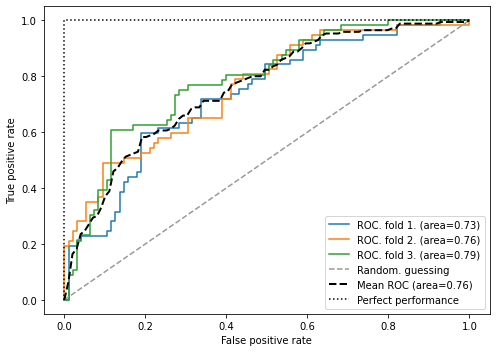

In [13]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
#import numpy as np
from sklearn.model_selection import StratifiedKFold

#スケーリング，PCA，ロジスティック回帰を指定してPipelineクラスをインスタンス化
pipe_lr=make_pipeline(StandardScaler(), PCA(n_components=2),
                                         LogisticRegression(penalty='l2',  random_state=1,
                                                                           solver='lbfgs',  C=100.0))

#２つの特徴量を抽出
X_train2=X_train[:,[4,14]]

#層化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv=list(StratifiedKFold(n_splits=3).split(X_train,  y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr=0.0

#0から1までの間で100個の要素を生成
mean_fpr=np.linspace(0,1,100)
all_tpr=[]
for i,  (train,test)  in enumerate(cv):
    
    #predict_probaメソッドで確率を予測，fitメソッドでモデルに適合させる
    probas=pipe_lr.fit(X_train2[train],
                                     y_train[train]).predict_proba(X_train2[test])
    
    #roc_curve関数でROC曲線の性能を計算してプロット
    fpr,tpr, thresholds=roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr+=interp(mean_fpr,  fpr,  tpr)  #FPR(X軸) とTPR(Y軸)を線形補間
    mean_tpr[0]=0.0
    roc_auc=auc(fpr, tpr)  #曲線下面積(AUC)を計算
    plt.plot(fpr,  tpr,  label='ROC. fold %d. (area=%0.2f)' %  (i+1,  roc_auc))
    
#当て推量をプロット
plt.plot([0,1],[0,1],
              linestyle='--',  color=(0.6,0.6,0.6),label='Random. guessing')

#FPR, TPR, ROC,AUCそれぞれの平均を計算してプロット
mean_tpr/=len(cv)
mean_tpr[-1]=1.0
mean_auc=auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr,  'k--',
              label='Mean ROC (area=%0.2f)' % mean_auc,lw=2)

#完全に予測が正解した時のROC曲線をプロット
plt.plot([0,0,1],[0,1,1],
              linestyle=':', color='black',label='Perfect performance')

#グラフの各項目を指定
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 6.5.4　　　多クラス分類のための性能指標

# - マクロ平均法
<br>
  各クラスごとに指標を算出してから平均をとる
  <img src="マクロ.png"  width="200">
  
<br>
<br>

# - マイクロ平均法
<br>
   全クラスでいっせいに指標を計算する
   <img src="マクロ平均法.png"  width="300">
<br>
  


In [14]:
pre_scorer=make_scorer(score_func=precision_score,
                                              pos_label=1,
                                              greater_is_better=True,
                                              average='micro')

# 6.6  クラスの不均衡に対処する



In [59]:
#357個の良性腫瘍のデータ点を全て選択し，最初の40個の悪性腫瘍のデータ点を結合している
x_imb=np.vstack((X[y==0], X[y==1][:40]))  #最初の４０個の悪性腫瘍のデータ点
y_imb=np.hstack((y[y==0], y[y==1][:40]))

In [60]:
y_pred=np.zeros(y_imb.shape[0])
np.mean(y_pred==y_imb)*100

89.92443324937027

In [61]:
from sklearn.utils import resample
print('Number of class 1 examples before:', x_imb[y_imb==1].shape[0])

#データ点の個数がクラス０と同じになるまで新しいデータ点を復元抽出
X_upsampled,y_upsampled=resample(x_imb[y_imb==1],
                                y_imb[y_imb==1],
                                replace=True,
                                n_samples=x_imb[y_imb==0].shape[0],
                                random_state=123)
print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [18]:
x_bal=np.vstack((X[y==0], X_upsampled))
y_bal=np.hstack((y[y==0], y_upsampled))

In [19]:
y_pred=np.zeros(y_bal.shape[0])
np.mean(y_pred==y_bal)*100

50.0